## Importing Libraries and Loading Data

In [1]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# interpretation
import shap
from interpret import show

# pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

## Data Exploration

In [2]:
df_weekly = nfl.import_weekly_data([2021, 2022, 2023])
df_weekly = df_weekly[df_weekly['season_type']=='REG']
df_weekly = df_weekly[df_weekly['position']=='QB']
df_weekly.info()

Downcasting floats.
<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 0 to 5636
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_id                    1994 non-null   object 
 1   player_name                  1994 non-null   object 
 2   player_display_name          1994 non-null   object 
 3   position                     1994 non-null   object 
 4   position_group               1994 non-null   object 
 5   headshot_url                 1994 non-null   object 
 6   recent_team                  1994 non-null   object 
 7   season                       1994 non-null   int32  
 8   week                         1994 non-null   int32  
 9   season_type                  1994 non-null   object 
 10  opponent_team                1994 non-null   object 
 11  completions                  1994 non-null   int32  
 12  attempts                     1994 non-null   int32  
 13  pas

In [3]:
df_weekly.isnull().sum()

player_id                         0
player_name                       0
player_display_name               0
position                          0
position_group                    0
headshot_url                      0
recent_team                       0
season                            0
week                              0
season_type                       0
opponent_team                     0
completions                       0
attempts                          0
passing_yards                     0
passing_tds                       0
interceptions                     0
sacks                             0
sack_yards                        0
sack_fumbles                      0
sack_fumbles_lost                 0
passing_air_yards                 0
passing_yards_after_catch         0
passing_first_downs               0
passing_epa                      95
passing_2pt_conversions           0
pacr                            104
dakota                          245
carries                     

In [4]:
df_weekly.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,27.160000,27.160000
1,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,2,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,29.639999,29.639999
2,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,3,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,28.680000,28.680000
3,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,4,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,11.060000,11.060000
4,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,TB,2021,5,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,37.740002,37.740002


In [5]:
df_weekly.columns

Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_tds', 'fantasy_points

In [6]:
columns_to_drop = ['headshot_url', 'season_type', 'sack_yards',
        'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
        'passing_yards_after_catch', 'passing_first_downs',
        'passing_epa', 'pacr', 'dakota', 'sacks', 
        'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
        'receiving_fumbles_lost', 'receiving_yards_after_catch',
        'receiving_first_downs', 'receiving_epa', 'racr',
        'target_share', 'air_yards_share', 'wopr',
        'special_teams_tds', 'player_display_name',
        'receiving_air_yards', 'player_name', 
        'position_group', 'fantasy_points', 'fantasy_points_ppr']

In [7]:
df_weekly = df_weekly.drop(columns=columns_to_drop)

In [8]:
df_weekly['player_id'] = df_weekly['player_id'].str.replace('00-', '').astype(int)

In [9]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 0 to 5636
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  1994 non-null   int64  
 1   position                   1994 non-null   object 
 2   recent_team                1994 non-null   object 
 3   season                     1994 non-null   int32  
 4   week                       1994 non-null   int32  
 5   opponent_team              1994 non-null   object 
 6   completions                1994 non-null   int32  
 7   attempts                   1994 non-null   int32  
 8   passing_yards              1994 non-null   float32
 9   passing_tds                1994 non-null   int32  
 10  interceptions              1994 non-null   float32
 11  passing_2pt_conversions    1994 non-null   int32  
 12  carries                    1994 non-null   int32  
 13  rushing_yards              1994 non-null   float32
 1

In [10]:
df_weekly.isnull().sum()

player_id                    0
position                     0
recent_team                  0
season                       0
week                         0
opponent_team                0
completions                  0
attempts                     0
passing_yards                0
passing_tds                  0
interceptions                0
passing_2pt_conversions      0
carries                      0
rushing_yards                0
rushing_tds                  0
rushing_fumbles              0
rushing_2pt_conversions      0
receptions                   0
targets                      0
receiving_yards              0
receiving_tds                0
receiving_fumbles            0
receiving_2pt_conversions    0
dtype: int64

## Feature Selection

In [11]:
X = df_weekly.drop(columns=['passing_yards', 'passing_tds', 
                            'passing_2pt_conversions', 
                            'rushing_yards', 
                            'rushing_tds', 
                            'rushing_2pt_conversions', 
                            'receiving_yards', 
                            'receiving_tds', 
                            'receiving_2pt_conversions', 
                            'attempts', 'completions', 'carries',
                            'targets', 'receptions',
                            'rushing_fumbles',
                            'receiving_fumbles',
                            'interceptions'])
X

,player_id,position,recent_team,season,week,opponent_team
0,19596,QB,TB,2021,1,DAL
1,19596,QB,TB,2021,2,ATL
2,19596,QB,TB,2021,3,LA
3,19596,QB,TB,2021,4,NE
4,19596,QB,TB,2021,5,MIA
...,...,...,...,...,...,...
5630,39163,QB,HOU,2023,18,IND
5633,39164,QB,IND,2023,1,JAX
5634,39164,QB,IND,2023,2,HOU
5635,39164,QB,IND,2023,4,LA


In [ ]:
# y = df_weekly[['passing_yards', 'passing_tds', 'passing_2pt_conversions', 
#               'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 
#               'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 
#                'attempts', 'completions', 'carries', 'targets',
#                'receptions', 'rushing_fumbles', 'receiving_fumbles',
#                'interceptions']]

y = df_weekly['passing_yards']

           player_id    season      week
player_id   1.000000  0.264617  0.024177
season      0.264617  1.000000  0.007488
week        0.024177  0.007488  1.000000


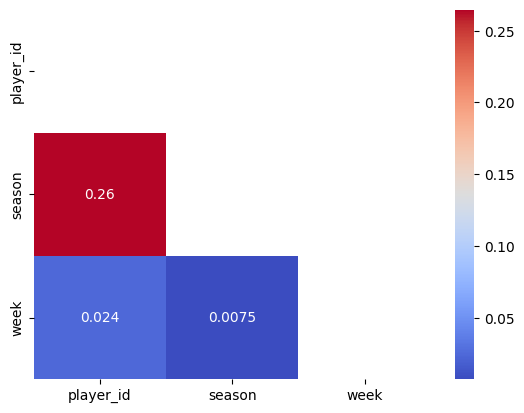

In [13]:
corr = X.select_dtypes('number').corr()
print(corr)
sns.heatmap(corr, annot=True, mask=np.triu(corr), cmap='coolwarm')
plt.show()

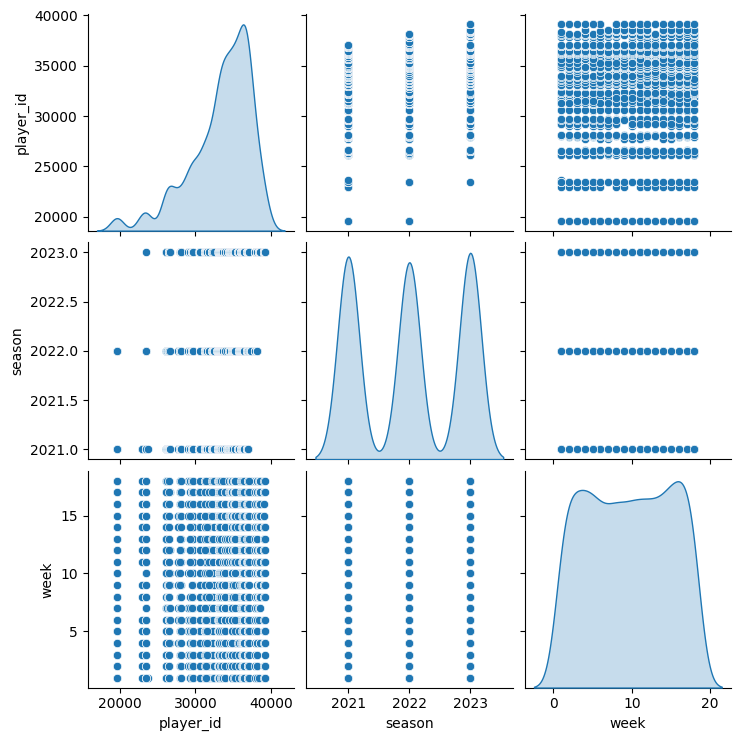

In [14]:
sns.pairplot(X, diag_kind='kde')

## Feature Encoding

In [15]:
X = pd.get_dummies(X, columns=['recent_team', 'opponent_team', 'position'], drop_first=True)
X

,player_id,season,week,recent_team_ATL,recent_team_BAL,recent_team_BUF,recent_team_CAR,recent_team_CHI,recent_team_CIN,recent_team_CLE,...,opponent_team_NO,opponent_team_NYG,opponent_team_NYJ,opponent_team_PHI,opponent_team_PIT,opponent_team_SEA,opponent_team_SF,opponent_team_TB,opponent_team_TEN,opponent_team_WAS
0,19596,2021,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,19596,2021,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,19596,2021,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,19596,2021,4,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,19596,2021,5,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,39163,2023,18,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5633,39164,2023,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5634,39164,2023,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5635,39164,2023,4,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Outlier Handling

player_id                       Axes(0.125,0.11;0.036215x0.77)
completions                  Axes(0.168458,0.11;0.036215x0.77)
attempts                     Axes(0.211916,0.11;0.036215x0.77)
passing_yards                Axes(0.255374,0.11;0.036215x0.77)
passing_tds                  Axes(0.298832,0.11;0.036215x0.77)
interceptions                 Axes(0.34229,0.11;0.036215x0.77)
passing_2pt_conversions      Axes(0.385748,0.11;0.036215x0.77)
carries                      Axes(0.429206,0.11;0.036215x0.77)
rushing_yards                Axes(0.472664,0.11;0.036215x0.77)
rushing_tds                  Axes(0.516121,0.11;0.036215x0.77)
rushing_fumbles              Axes(0.559579,0.11;0.036215x0.77)
rushing_2pt_conversions      Axes(0.603037,0.11;0.036215x0.77)
receptions                   Axes(0.646495,0.11;0.036215x0.77)
targets                      Axes(0.689953,0.11;0.036215x0.77)
receiving_yards              Axes(0.733411,0.11;0.036215x0.77)
receiving_tds                Axes(0.776869,0.11;0.03621

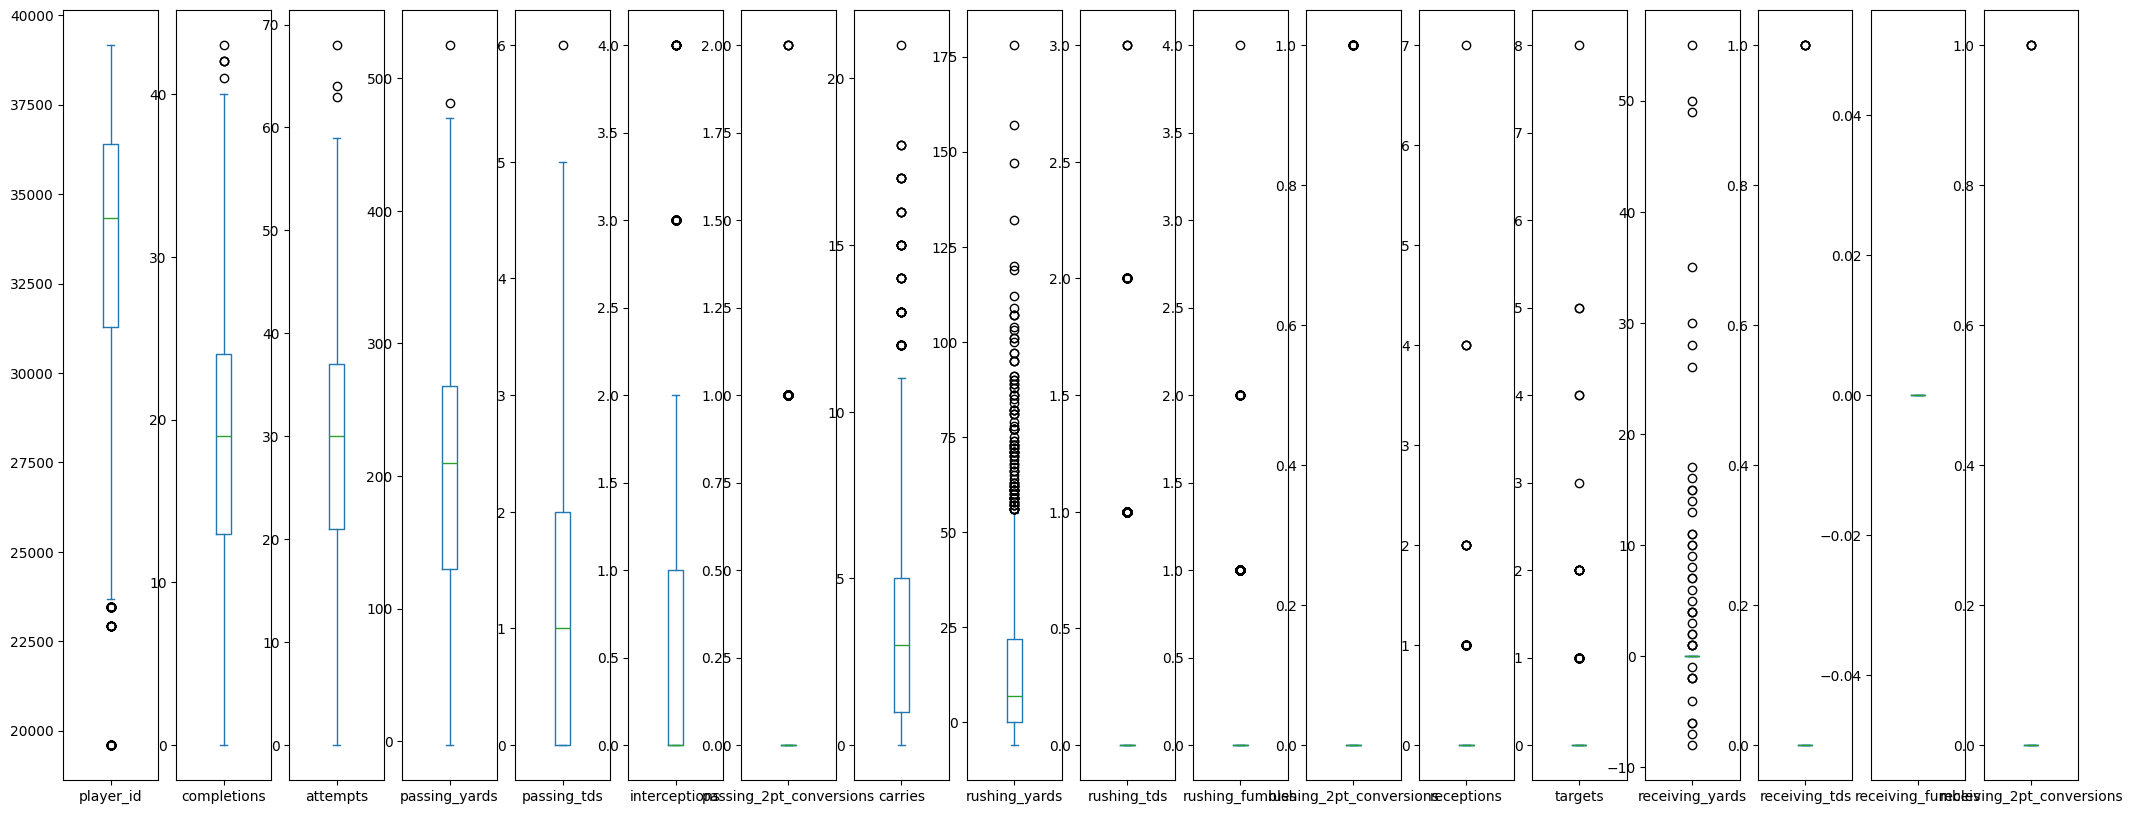

In [16]:
df_weekly.drop(columns=['season', 'week']).plot.box(subplots=True, figsize=(26,10))

/Users/simonmuhlbauer/Desktop/Uni/Master/WiSe_24-25/DSAI/Projekt/venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='rushing_yards', ylabel='carries'>

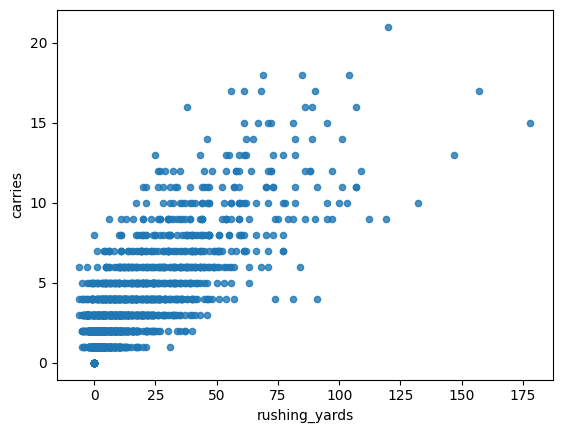

In [17]:
df_weekly.plot.scatter('rushing_yards', 'carries', cmap='coolwarm', alpha=.8)

## Data Splitting

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1595 entries, 104 to 3583
Data columns (total 65 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   player_id          1595 non-null   int64
 1   season             1595 non-null   int32
 2   week               1595 non-null   int32
 3   recent_team_ATL    1595 non-null   bool 
 4   recent_team_BAL    1595 non-null   bool 
 5   recent_team_BUF    1595 non-null   bool 
 6   recent_team_CAR    1595 non-null   bool 
 7   recent_team_CHI    1595 non-null   bool 
 8   recent_team_CIN    1595 non-null   bool 
 9   recent_team_CLE    1595 non-null   bool 
 10  recent_team_DAL    1595 non-null   bool 
 11  recent_team_DEN    1595 non-null   bool 
 12  recent_team_DET    1595 non-null   bool 
 13  recent_team_GB     1595 non-null   bool 
 14  recent_team_HOU    1595 non-null   bool 
 15  recent_team_IND    1595 non-null   bool 
 16  recent_team_JAX    1595 non-null   bool 
 17  recent_team_KC   

In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, 1042 to 914
Data columns (total 65 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   player_id          399 non-null    int64
 1   season             399 non-null    int32
 2   week               399 non-null    int32
 3   recent_team_ATL    399 non-null    bool 
 4   recent_team_BAL    399 non-null    bool 
 5   recent_team_BUF    399 non-null    bool 
 6   recent_team_CAR    399 non-null    bool 
 7   recent_team_CHI    399 non-null    bool 
 8   recent_team_CIN    399 non-null    bool 
 9   recent_team_CLE    399 non-null    bool 
 10  recent_team_DAL    399 non-null    bool 
 11  recent_team_DEN    399 non-null    bool 
 12  recent_team_DET    399 non-null    bool 
 13  recent_team_GB     399 non-null    bool 
 14  recent_team_HOU    399 non-null    bool 
 15  recent_team_IND    399 non-null    bool 
 16  recent_team_JAX    399 non-null    bool 
 17  recent_team_KC    

## Feature Scaling

In [20]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

In [21]:
type(X_train)
X_train

,player_id,season,week,recent_team_ATL,recent_team_BAL,recent_team_BUF,recent_team_CAR,recent_team_CHI,recent_team_CIN,recent_team_CLE,...,opponent_team_NO,opponent_team_NYG,opponent_team_NYJ,opponent_team_PHI,opponent_team_PIT,opponent_team_SEA,opponent_team_SF,opponent_team_TB,opponent_team_TEN,opponent_team_WAS
0,-0.862034,1.210467,-1.434564,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,-0.170389,-0.179896,-0.174246,-0.183577,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,-0.181745
1,0.901931,1.210467,-1.055012,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,-0.170389,-0.179896,-0.174246,-0.183577,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,-0.181745
2,-3.299790,-0.009947,0.652972,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,5.868939,-0.179896,-0.174246,-0.183577,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,-0.181745
3,0.471313,-0.009947,-0.865236,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,-0.170389,-0.179896,-0.174246,5.447300,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,-0.181745
4,0.162764,1.210467,-0.295908,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,-0.170389,-0.179896,-0.174246,-0.183577,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,-0.181745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,0.708696,-0.009947,-0.295908,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,-0.170389,-0.179896,-0.174246,-0.183577,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,-0.181745
1591,1.164644,-0.009947,0.463196,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,-0.170389,-0.179896,-0.174246,-0.183577,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,-0.181745
1592,-0.355666,-0.009947,0.652972,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,-0.170389,5.558777,-0.174246,-0.183577,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,-0.181745
1593,-0.047599,1.210467,0.463196,-0.179896,-0.16843,-0.181745,-0.176147,-0.176147,-0.172327,-0.17803,...,-0.170389,-0.179896,-0.174246,-0.183577,-0.176147,-0.16843,-0.181745,-0.183577,-0.181745,5.502228


In [22]:
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test
type(X_test)

pandas.core.frame.DataFrame

## Extreme Gradient Boosting

In [23]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
xgb.score(X_test, y_test)

0.24491703510284424

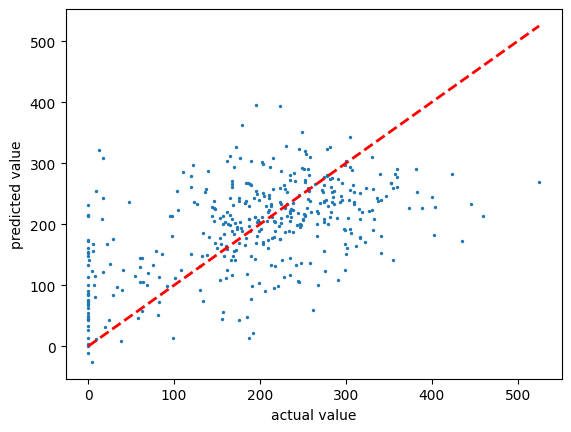

In [25]:
def plotResult(y_test,y_pred):
  plt.scatter(y_test, y_pred, s = 2)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
  plt.xlabel('actual value')
  plt.ylabel('predicted value')
  plt.show()

plotResult(y_test, xgb.predict(X_test))

## Classification

In [26]:
threshold = y_train.median()

In [27]:
y_train_class = y_train <= threshold
y_test_class = y_test <= threshold
print(y_train.shape)         # Länge von y_train
print(len(y_train_class))   # Länge von y_train_class
print(type(y_train))        # Sollte eine Pandas Series oder ein Numpy Array sein
print(type(y_train_class))  # Sollte ebenfalls eine Pandas Series oder ein Numpy Array sein
# Problem: Mehr als ein target value in y

(1595,)
1595
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [28]:
print(threshold)

211.0


In [29]:
pd.DataFrame({"regression": y_train, "classification":y_train_class})

,regression,classification
104,246.0,False
3862,245.0,False
11,281.0,False
2896,250.0,False
1436,208.0,True
...,...,...
3587,382.0,False
5525,174.0,True
736,275.0,False
817,331.0,False


In [30]:
y_train_class.mean()

np.float64(0.503448275862069)

In [31]:
clf = XGBClassifier()
clf.fit(X_train, y_train_class)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
clf.predict(X_test)

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,

In [33]:
clf.predict_proba(X_test)

array([[0.5617665 , 0.43823352],
       [0.4199016 , 0.5800984 ],
       [0.6143244 , 0.3856756 ],
       [0.670384  , 0.329616  ],
       [0.3139773 , 0.6860227 ],
       [0.6577456 , 0.34225437],
       [0.5714469 , 0.42855313],
       [0.6151184 , 0.38488165],
       [0.13032073, 0.8696793 ],
       [0.21438915, 0.78561085],
       [0.13374937, 0.86625063],
       [0.64028627, 0.35971373],
       [0.2672298 , 0.7327702 ],
       [0.7985238 , 0.20147623],
       [0.4018191 , 0.5981809 ],
       [0.88244563, 0.11755439],
       [0.48796183, 0.5120382 ],
       [0.27882904, 0.72117096],
       [0.93679065, 0.06320934],
       [0.20577717, 0.79422283],
       [0.7244357 , 0.27556428],
       [0.03006756, 0.96993244],
       [0.18637305, 0.81362695],
       [0.24376684, 0.75623316],
       [0.02246761, 0.9775324 ],
       [0.6888741 , 0.3111259 ],
       [0.8254929 , 0.17450708],
       [0.12162894, 0.87837106],
       [0.5518056 , 0.44819435],
       [0.7897302 , 0.21026981],
       [0.

In [34]:
assert (clf.predict(X_test) == (clf.predict_proba(X_test)[:,1] >= 0.5)).all()

In [35]:
pd.DataFrame({'actual':y_test_class.astype(int), 'predicted':clf.predict(X_test), 'probability':clf.predict_proba(X_test)[:,1]})

,actual,predicted,probability
1042,0,0,0.438234
2316,1,1,0.580098
3200,0,0,0.385676
1873,0,0,0.329616
508,0,1,0.686023
...,...,...,...
1152,0,0,0.031631
1151,0,0,0.237716
5005,0,0,0.464178
1396,1,1,0.926051


## Model Evaluation

In [36]:
def printMetricResults(metric):
    for name, model in zip(
        ['Linear Regression', 'Explainable Boosting Machine', 'Multi Layer Perceptron', 'XGBoost'],
        [lr, ebm, mlp, xgb]
    ):
        print(f'{name:30}{metric(y_test, model.predict(X_test))}')

In [37]:
print(mean_absolute_error(y_test, xgb.predict(X_test)))
print(mean_squared_error(y_test, xgb.predict(X_test)))
print(root_mean_squared_error(y_test, xgb.predict(X_test)))
print(r2_score(y_test, xgb.predict(X_test)))


71.30297
8433.359
91.83332
0.24491703510284424


### Evaluation of (binary) classifiers

In [38]:
y_pred = clf.predict(X_test)

In [39]:
matrix = confusion_matrix(y_test_class, y_pred) # for labels 0, 1, ...
matrix
#             Matrix:
# True negative  | False positive
# -------------------------------
# False negative | True positive

array([[119,  68],
       [ 77, 135]])

In [40]:
accuracy_score(y_test_class, y_pred)

0.6365914786967418

In [41]:
precision_score(y_test_class, y_pred)

np.float64(0.6650246305418719)

In [42]:
recall_score(y_test_class, y_pred)

np.float64(0.6367924528301887)

In [43]:
f1_score(y_test_class, y_pred)

np.float64(0.6506024096385542)

## Hyperparameter Optimization and Cross-Validation

In [44]:
xgb_grid = {
    "max_depth": [3, 6, 9, None],
    "learning_rate": [0.1, 0.3],
    "n_estimators": [100, 500, 1000, 2000]
}

In [45]:
models = []
for max_depth in xgb_grid['max_depth']:
    for learning_rate in xgb_grid['learning_rate']:
        for n_estimators in xgb_grid['n_estimators']:
            model = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators).fit(X_train, y_train)
            score = model.score(X_test, y_test)
            md = max_depth if max_depth else 'None'
            print(f'max_depth={md:4}, {learning_rate=:3}, {n_estimators=:4}:', score)
            models.append((max_depth, learning_rate, n_estimators, score))

max_depth=   3, learning_rate=0.1, n_estimators= 100: 0.2513318657875061
max_depth=   3, learning_rate=0.1, n_estimators= 500: 0.2981398105621338
max_depth=   3, learning_rate=0.1, n_estimators=1000: 0.2790306806564331
max_depth=   3, learning_rate=0.1, n_estimators=2000: 0.22479641437530518
max_depth=   3, learning_rate=0.3, n_estimators= 100: 0.2791934013366699
max_depth=   3, learning_rate=0.3, n_estimators= 500: 0.22758054733276367
max_depth=   3, learning_rate=0.3, n_estimators=1000: 0.16637223958969116
max_depth=   3, learning_rate=0.3, n_estimators=2000: 0.08981621265411377
max_depth=   6, learning_rate=0.1, n_estimators= 100: 0.2744717001914978
max_depth=   6, learning_rate=0.1, n_estimators= 500: 0.2029598355293274
max_depth=   6, learning_rate=0.1, n_estimators=1000: 0.15249121189117432
max_depth=   6, learning_rate=0.1, n_estimators=2000: 0.13145345449447632
max_depth=   6, learning_rate=0.3, n_estimators= 100: 0.24491703510284424
max_depth=   6, learning_rate=0.3, n_estimat

In [46]:
pd.DataFrame(models, columns=['max_depth', 'learning_rate', 'n_estimators', 'score']).sort_values(by='score', ascending=False)

,max_depth,learning_rate,n_estimators,score
1,3.0,0.1,500,0.298140
4,3.0,0.3,100,0.279193
2,3.0,0.1,1000,0.279031
8,6.0,0.1,100,0.274472
24,NaN,0.1,100,0.274472
16,9.0,0.1,100,0.273032
0,3.0,0.1,100,0.251332
12,6.0,0.3,100,0.244917
28,NaN,0.3,100,0.244917
5,3.0,0.3,500,0.227581


In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
gridSearch = GridSearchCV(XGBRegressor(), xgb_grid, verbose=2, cv=3)
gridSearch.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.2s
[CV] END ..learning_rate=0.1, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END ..learning_rate=0.1, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END ..learning_rate=0.1, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END ..learning_rate=0.1, max_depth=3, n_estimators=2000; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=3, n_estimators=2000; total time=   0.9s
[CV] END ..learning_rate=0.1, max_depth=3, n_est

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.3],
                         'max_depth': [3, 6, 9, None],
                         'n_estimators': [100, 500, 1000, 2000]},
             verbose=2)

In [49]:
results = pd.DataFrame(gridSearch.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.058090,0.004748,0.005517,0.000472,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.246808,0.226752,0.239710,0.237756,0.008304,6
1,0.237341,0.000527,0.005490,0.000109,0.1,3,500,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.271297,0.204639,0.318196,0.264711,0.046592,4
2,0.463626,0.000653,0.006035,0.000269,0.1,3,1000,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.266528,0.143835,0.272825,0.227729,0.059378,7
3,0.914969,0.001314,0.006481,0.000072,0.1,3,2000,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.240061,0.084008,0.220553,0.181541,0.069424,13
4,0.097049,0.001784,0.005507,0.000274,0.1,6,100,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.279677,0.242405,0.288210,0.270097,0.019889,2
5,0.437345,0.002556,0.005926,0.000068,0.1,6,500,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.206239,0.140173,0.212835,0.186416,0.032809,11
6,0.880192,0.010361,0.007050,0.000291,0.1,6,1000,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.183962,0.106132,0.185248,0.158448,0.036996,21
7,1.781884,0.047365,0.008817,0.000387,0.1,6,2000,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.177783,0.098862,0.178197,0.151614,0.037302,23
8,0.146179,0.002838,0.005701,0.000357,0.1,9,100,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti...",0.251333,0.199905,0.275720,0.242319,0.031600,5
9,0.705659,0.012721,0.006758,0.000033,0.1,9,500,"{'learning_rate': 0.1, 'max_depth': 9, 'n_esti...",0.181232,0.114115,0.208155,0.167834,0.039543,18


In [50]:
bestModel = gridSearch.best_estimator_.fit(X_train, y_train)
bestModel.score(X_test, y_test)

0.2791934013366699

## Deployment

In [51]:
import pickle

In [52]:
with open('trained-ebm-model.pkl', 'wb') as file:
    pickle.dump(bestModel, file)

## Data Leakage

In [53]:
## Nothing to be done yet -> No missing values means no imputation

## Overfitting

In [54]:
from sklearn.tree import DecisionTreeRegressor

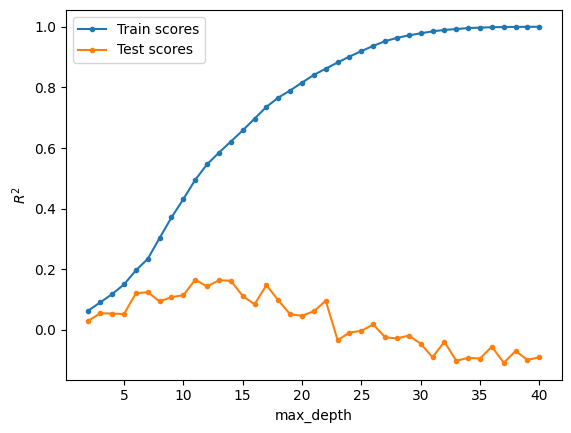

In [55]:
# init empty lists for scores
train_scores = []
test_scores = []

# lets test from max_depth 2 to 40
r = range(2, 41)
for max_depth in r:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42).fit(X_train, y_train)
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))

# create plot
plt.plot(r, train_scores, label='Train scores', marker='.')
plt.plot(r, test_scores, label='Test scores', marker='.')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('$R^2$')
plt.show()